In [1]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import median_filter

def medfilt3(volume, kernel_size):
    filtered_volume = np.copy(volume)
    for channel in range(filtered_volume.shape[2]):
        filtered_volume[:, :, channel] = median_filter(volume[:, :, channel], size=kernel_size)
    return filtered_volume

def convert_to_multi_channel(images):
    # Get the shape of a single image
    image_shape = images[0].shape

    # Create an empty multi-channel 3D image
    num_images = len(images)
    multi_channel_image = np.zeros((image_shape[0], image_shape[1], num_images), dtype=np.uint8)

    # Stack the images as channels of the multi-channel image
    for i in range(num_images):
        multi_channel_image[:, :, i] = images[i]

    return multi_channel_image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Specify the path to your TIFF image
image_path = r'testimages/2022.12.21_APS018_Infection_PA14-GacA_40X_40%_EM-4_D2_3_7047.tif'

# Call the function to split the TIFF into separate pages
image = Image.open(image_path)

num_pages = 0
base_name = image.filename
images = []
try:
    # Iterate through each page and save it as a separate numpy array
    while True:
        image.seek(num_pages)
        img = np.array(image)
        images.append(img)
        num_pages += 1
except EOFError:
    pass

if num_pages > 0:
    print(f'TIFF image successfully split into {num_pages} pages.')
else:
    print('The provided image is not a multi-page TIFF.')

TIFF image successfully split into 14 pages.


In [3]:
for img in images:
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
equalised_images = []
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10,10))

for i in range(len(images)):
    images[i] = clahe.apply(images[i])
    equalised_images.append(images[i])

In [32]:
for eqimg in equalised_images:
    cv2.imshow('image', eqimg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [33]:
# for i in range(len(med_blur_images)):
#     med_blur_images[i]  = np.uint8(med_blur_images[i])

In [34]:
med_blur_images = []
for i in range(len(equalised_images)):
    scaled_image = cv2.normalize(equalised_images[i], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    medimg = cv2.medianBlur(scaled_image, 21)
    med_blur_images.append(medimg)

# # med_blur_images = []
# # kernel_size = (3, 3, 3)  # Adjust the kernel size as desired

# # for i in range(len(equalised_images)):
# #     medimg = np.copy(equalised_images[i])
# #     for channel in range(medimg.shape[2]):
# #         medimg[:, :, channel] = cv2.medianBlur(equalised_images[i][:, :, channel], kernel_size[0])
# #     med_blur_images.append(medimg)

# med_blur_images = []
# kernel_size = (1,1,1)  # Adjust the kernel size as desired

# # Convert the images to a multi-channel 3D image
# multi_channel_image = convert_to_multi_channel(images).astype(np.uint8)

# # Apply the median filter to the multi-channel image
# med_blur_image = medfilt3(multi_channel_image, kernel_size)

# # Separate the channels back into individual images
# med_blur_images = []
# for i in range(med_blur_image.shape[2]):
#     med_blur_images.append(med_blur_image[:, :, i])

In [35]:
for med_img in med_blur_images:
    cv2.imshow('image', med_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [36]:
binary_images = []
for med_img in med_blur_images:
    _, binary_image = cv2.threshold(med_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # _, binary_image = cv2.threshold(eqimg, 0, 255, cv2.THRESH_BINARY)
    binary_images.append(binary_image)

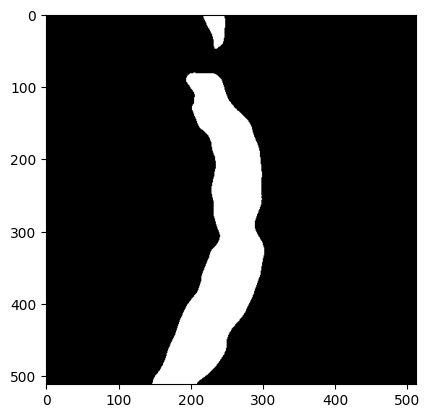

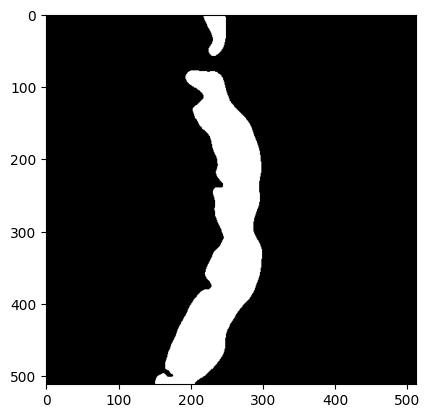

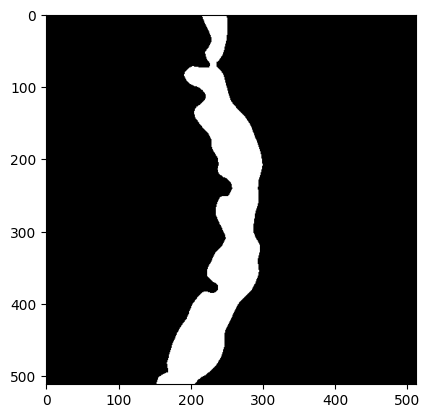

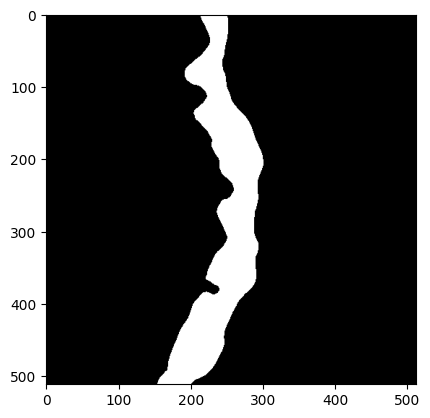

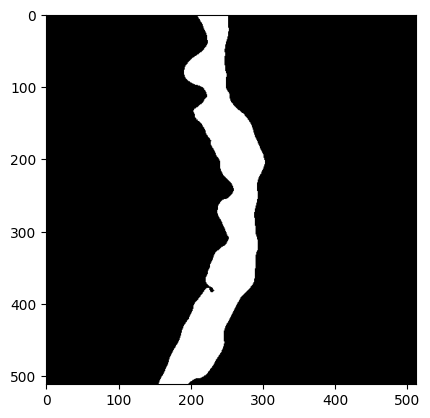

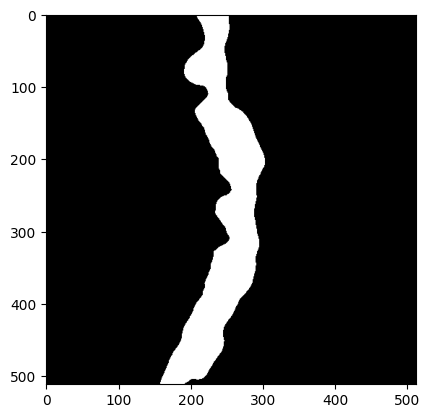

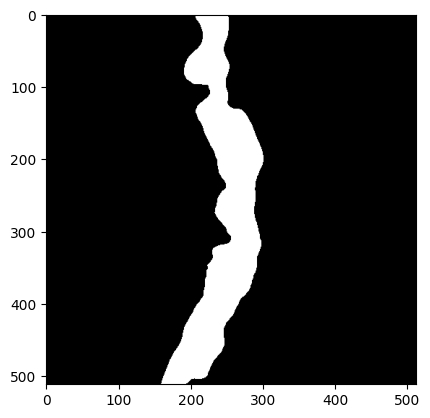

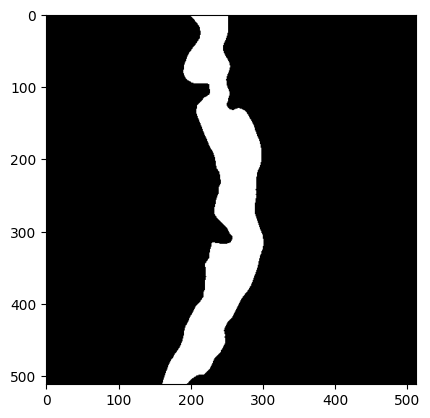

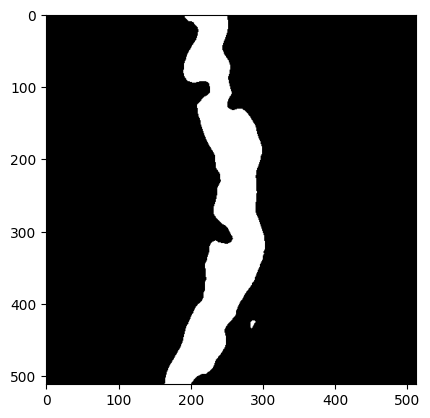

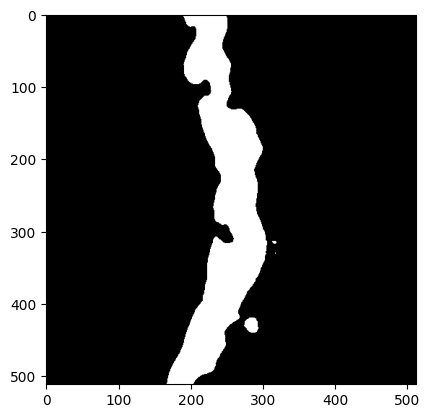

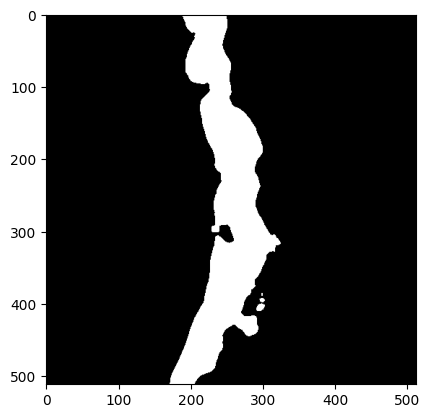

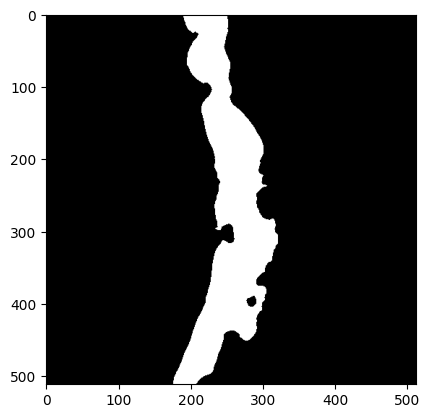

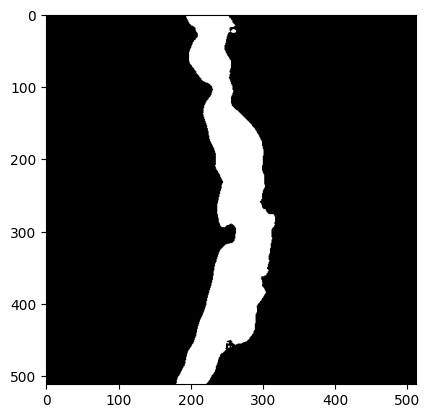

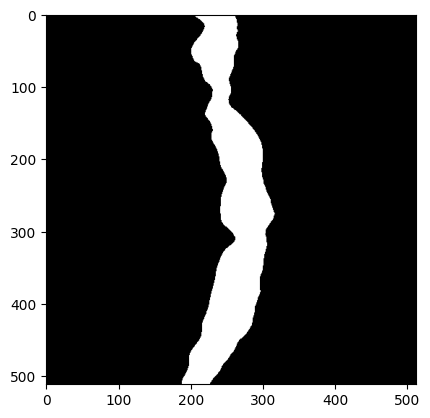

In [37]:
for bin_img in binary_images:
    plt.imshow(bin_img, cmap='gray')
    plt.show()

In [38]:
kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

# Apply morphological closing operation to each binary image
closed_images = []
for binary_image in binary_images:
    closed_img = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel, iterations=5)
    closed_images.append(closed_img)

In [39]:
# Extract pixel coordinates and map them to 3D space
coords = []
for i, image in enumerate(closed_images):
    coords_i = np.column_stack(np.where(image > 0))
    coords_i = np.hstack((coords_i, np.full((coords_i.shape[0], 1), -i)))  # Mapping to Z-coordinate
    coords.append(coords_i)

# Combine the pixel coordinates from all images
all_coords = np.concatenate(coords)

# Scale and normalize the coordinates
scale_factor_z = 4  # Adjust the scale factor for the z-axis as needed
all_coords[:, 2] = all_coords[:, 2] * scale_factor_z

# Calculate the center of the point cloud
center = np.mean(all_coords, axis=0)

# Translate the coordinates to center the point cloud
all_coords[:, 0] = all_coords[:, 0] - center[0]
all_coords[:, 1] = all_coords[:, 1] - center[1]
all_coords[:, 2] = all_coords[:, 2] - center[2]

# Create a point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(all_coords[:, [1, 0, 2]])  # Swap X and Y axes for Open3D

# Visualize the point cloud
downpcd = point_cloud.voxel_down_sample(voxel_size=0.01)

o3d.visualization.draw_geometries([point_cloud],
                                  zoom=1,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[0, 0, 0],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True,)
